# Magnetic Confinement Fusion Breeder Blanket Simulation
In this notebook we'll be exploring how to perform fixed source simulations with a fusion reactor geometry and obtain the Tritium Breeding Ratio (TBR) in the breeder blankets of a tokamak.

CAD based geometry has been used for this example via the [DagMC](https://svalinn.github.io/DAGMC/index.html) toolkit. The models we'll be using in this notebook have already been created using the [Paramak](https://github.com/ukaea/paramak) and faceted into a surface mesh using [Coreform-Cubit](https://coreform.com/products/coreform-cubit/) which is also able to export the mesh as `.h5m` files in the [Mesh Oriented DatABase](https://press3.mcs.anl.gov/sigma/moab-library/) format.

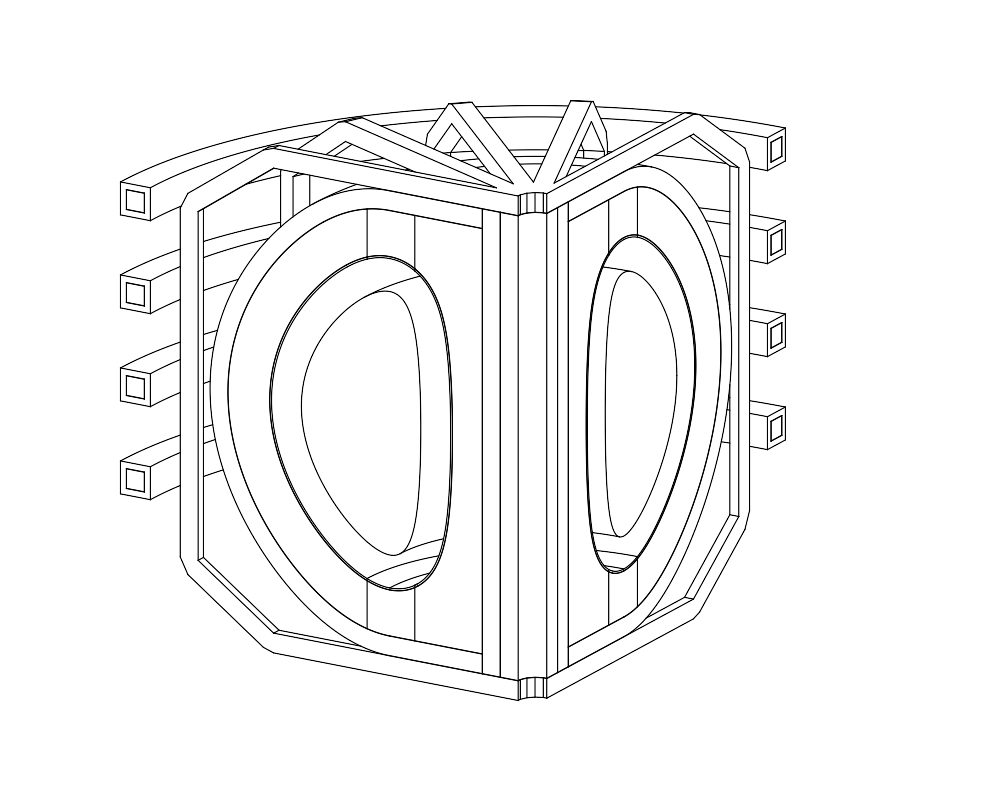

In [1]:
%matplotlib inline
from IPython.display import Image

Image("./images/paramak_mcf_reactor_sector.png", width=500)

We'll be retrieving the h5m file using the code block below.

In [2]:
import urllib.request

url='https://github.com/Shimwell/fusion_example_for_openmc_using_paramak/blob/main/dagmc.h5m?raw=true'  # 2.4 MB
u = urllib.request.urlopen(url)

if u.status != 200:
    raise RuntimeError("Failed to download file.")

# save file as dagmc.h5m
with open("dagmc.h5m", 'wb') as f:
    f.write(u.read())

This notebook is intended to demonstrate how to obtain TBR for a simple tokamak model. CAD based geometry using DagMC is particularly well suited to this problem as the implicite voids mean that the we can avoid making complex void geometry which would be particularly difficult around the toroidal field coils.

Now that we have downloaded the h5m geometry file we can inspect the materials tags to see which materials we need to create.

The following command runs a MOAB executable and searches the h5m file for material tags.

Assuming you have MOAB installed and mbsize in you PATH enviroment then the following command should return six materials:
   - tungsten is used for shielding and firstwall armour volumes
   - steel is used for the structural material volumes
   - flibe is used for the breeder material volume
   - copper is used for the magnet volumes
   - graveyard is the edge of th emodel universe and particles entering this vlume will no longer be tracked
   - Vacuum is the material assigned to the solid used to make the reflecting boundaries and does not need a material definition

In [3]:
!mbsize -ll dagmc.h5m | grep 'NAME = mat:'

    NAME = mat:tungsten
    NAME = mat:steel
    NAME = mat:flibe
    NAME = mat:copper
    NAME = mat:graveyard
    NAME = mat:Vacuum


Fusion reactors often make use of reduced activation materials and super conducting materials for the magnets. However To keep the example short we'll be using a simple materials.

In [4]:
import openmc

steel = openmc.Material(name="steel")
steel.add_element('Fe', 0.95, 'ao')
steel.add_element('C', 0.05, 'ao')
steel.set_density('g/cm3', 8)

copper = openmc.Material(name="copper")
copper.add_element('Cu', 2.0, 'ao')
copper.set_density('g/cm3', 19.3)

tungsten = openmc.Material(name="tungsten")
tungsten.add_element('W', 1.0, 'ao')
tungsten.set_density('g/cm3', 19.3)

flibe = openmc.Material(name="flibe")
flibe.add_elements_from_formula('F2Li2BeF2', enrichment=40, enrichment_target='Li6')
flibe.set_density('g/cm3', 1.94)

mats = openmc.Materials([steel, copper, tungsten, flibe])
mats.export_to_xml()

This section creates the geometry from the file we downloaded earlier.

In [5]:
dag_univ = openmc.DAGMCUniverse("dagmc.h5m")
geom = openmc.Geometry(root=dag_univ)
geom.export_to_xml()

The next stage is to assign the simulation settings. Assigning the inactive batch to 0 helps avoid unessecary compute for fixed-source simulations.

In [6]:
settings = openmc.Settings()
settings.batches = 10
settings.inactive = 0
settings.particles = 10000
settings.run_mode = "fixed source"

settings.export_to_xml()

Now that a settings.xml has been produced we can plot the model and use a color scheme to identify the location of different materials.

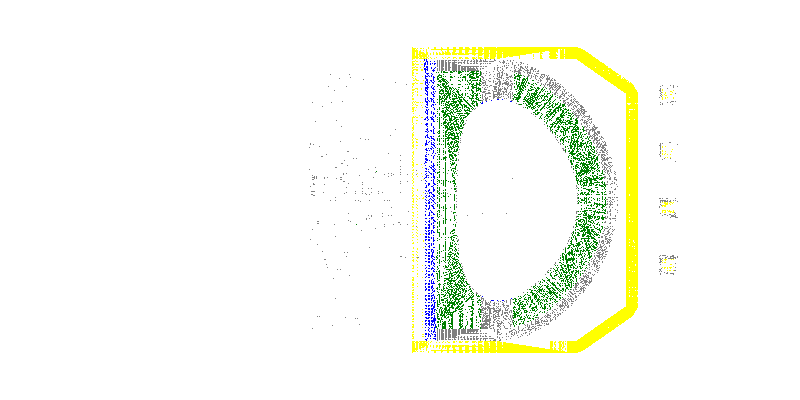

In [7]:
p = openmc.Plot()
p.width = (2000, 1000)
p.basis='xz'
p.pixels = (800, 400)
p.color_by = 'material'
p.colors = {steel: 'grey', tungsten: 'blue', flibe: 'green', copper: 'yellow'}
openmc.plot_inline(p)

Now that we've had a chance to examine the model a bit, we can finish applying our settings and add a ring source in the middle of the plasma chamber.

In [8]:
source = openmc.Source()

# the distribution of radius is just a single value at the plasma major radius
radius = openmc.stats.Discrete([293.], [1])

# the distribution of source z values is just a single value
z_values = openmc.stats.Discrete([0], [1])

# the distribution of source azimuthal angles values is a uniform distribution between 0 and 2 Pi
angle = openmc.stats.Uniform(a=0., b=0.5* 3.14159265359)

# this makes the ring source using the three distributions and a radius
source.space = openmc.stats.CylindricalIndependent(r=radius, phi=angle, z=z_values, origin=(0.0, 0.0, 0.0))

# sets the direction to isotropic
source.angle = openmc.stats.Isotropic()

# sets the energy distribution to a Muir distribution neutrons
source.energy = openmc.stats.Muir(e0=14080000.0, m_rat=5.0, kt=20000.0)

settings.source = source

settings.export_to_xml()

Tallies work in the same way when using DAGMC geometries too. We'll add a tally on the breeder blanket material here.

In [9]:
tally = openmc.Tally(name='TBR')
tally.scores = ['(n,Xt)']  # this catch all neutron induced tritium producing reactions
tally.filters = [openmc.MaterialFilter(flibe)]
tallies = openmc.Tallies([tally])
tallies.export_to_xml()

The next code block will remove old h5 files and run the simulation

In [10]:
!rm summary.h5 statepoint.10.h5
openmc.run()

rm: cannot remove 'summary.h5': No such file or directory
rm: cannot remove 'statepoint.10.h5': No such file or directory
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################   

The TBR result can now be found within the statepoint file.

In [11]:
sp = openmc.StatePoint('statepoint.10.h5')

# access the tally using pandas dataframes

tbr_tally = sp.get_tally(name='TBR')

df = tbr_tally.get_pandas_dataframe()

tbr_tally_result = df['mean'].sum()

tbr_tally_std_dev = df['std. dev.'].sum()

print('The tritium breeding ratio was found, TBR = ', tbr_tally_result)
print('Standard deviation on the tbr tally is ', tbr_tally_std_dev)

The tritium breeding ratio was found, TBR =  0.4887638269225465
Standard deviation on the tbr tally is  0.00334355420688029


A tritium production mesh tally can also show where the tritium is being produced

In [12]:
mesh = openmc.RegularMesh()
mesh.dimension = (300, 1, 250)
mesh.lower_left = (0., 0, -500.)
mesh.upper_right = (600., 1.0, 500.)

mesh_filter = openmc.MeshFilter(mesh)

tritium_tally = openmc.Tally()
tritium_tally.filters = [mesh_filter]
tritium_tally.scores = ['(n,Xt)']

tallies = openmc.Tallies([tritium_tally])
tallies.export_to_xml()

The tritium production mesh tally result can now be found within the statepoint file.

In [13]:
!rm summary.h5 statepoint.10.h5
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Plotting the mesh tally shows that the blanket is producing tritium predominantly at the plasma facing side.

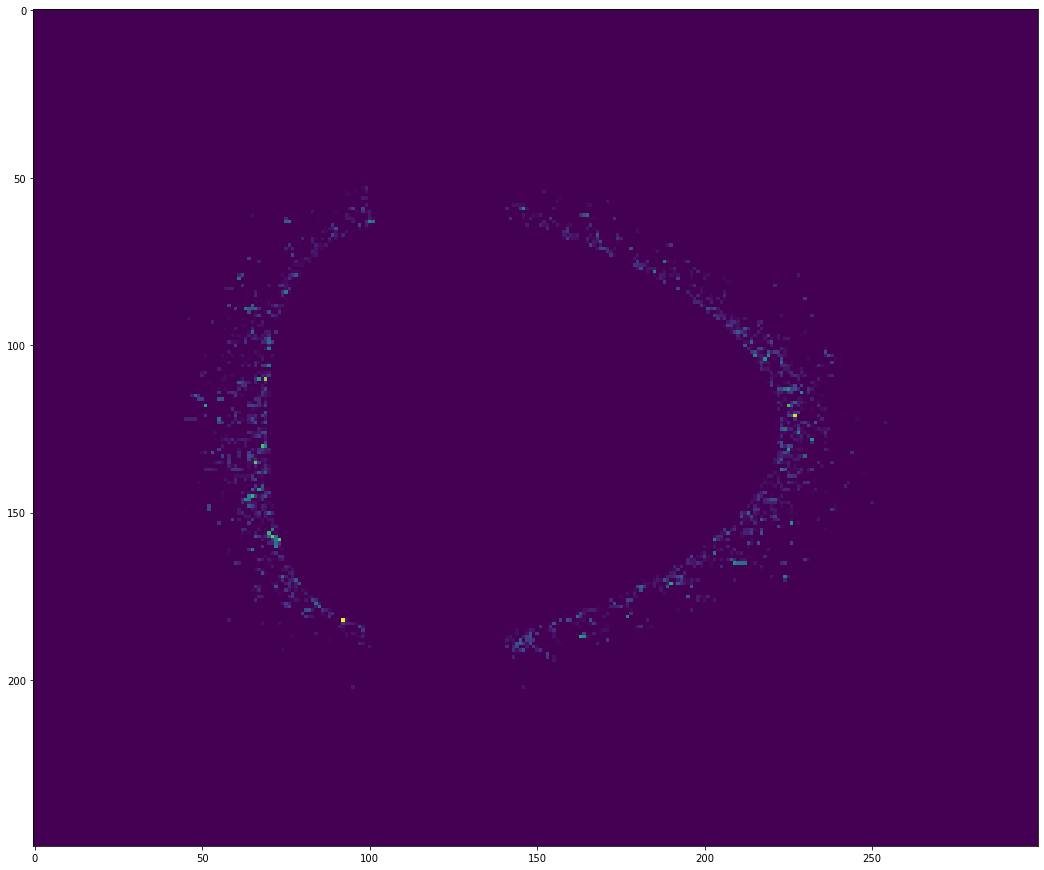

In [14]:
sp = openmc.StatePoint("statepoint.10.h5")

tritium_tally = sp.get_tally(scores=['(n,Xt)'])
tritium_production = tritium_tally.mean
tritium_production.shape = (250, 300)

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(18, 16))

plt.imshow(tritium_production)

If you are looking for more OpenMC fusion examples you might find this [fusion neutronics workshop](https://github.com/ukaea/openmc_workshop/) useful.